In [1]:
import os 
os.chdir ('/projects/bbhj/asinha15/VLQ-NN-Reweighting/main/')

In [2]:
from DNN.Data import CSVData
from XML.LRP import LRP
import numpy as np
import copy
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
model_path = 'trained_models/[29, 32, 64, 32, 32, 16, 8, 4].pt'
model = torch.jit.load(model_path).to(device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (Linear0): RecursiveScriptModule(original_name=Linear)
  (Activation0): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear1): RecursiveScriptModule(original_name=Linear)
  (Activation1): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear2): RecursiveScriptModule(original_name=Linear)
  (Activation2): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear3): RecursiveScriptModule(original_name=Linear)
  (Activation3): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear4): RecursiveScriptModule(original_name=Linear)
  (Activation4): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear5): RecursiveScriptModule(original_name=Linear)
  (Activation5): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear_last): RecursiveScriptModule(original_name=Linear)
)

In [5]:
features = ['mode',
'Msim',
'Gsim',
'pz_in1',
'pid_in1', 
'pz_in2',
'pid_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'pid_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'pid_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'pid_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'pid_out4',
'Mtarget',
'Gtarget',]
label = 'f_rwt'
features_to_rescale = ['Msim',
'Gsim',
'pz_in1', 
'pz_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'Mtarget',
'Gtarget']

In [6]:
train_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/projects/bbhj/asinha15/train_' + str(i)+'.csv' for i in range(0,10)])

In [7]:
X, Y = train_data.load_data_many()
X = np.array(X)
Y = np.log(np.array(Y))
for i in np.where(Y==0)[0]:
    Y[i] = 0.000001 #avoid div by 0

In [8]:
#start with LRP-0
def rho(w,l):  
    return w 
def incr(z,l): 
    return z
R_0 = LRP(model, rho, incr, X, Y)

In [9]:
#LRP-epsilon
def rho(w,l):  
    return w 
def incr(z,l): 
    epsilon = 1e-5
    return z + epsilon
R_epsilon = LRP(model, rho, incr, X, Y)

In [10]:
#LRP-gamma
def rho(w,l):  
    gamma = 1e-5
    wpos = np.maximum(0, w)
    return w + gamma * wpos
def incr(z,l): 
    return z
R_gamma = LRP(model, rho, incr, X, Y)

In [19]:
rel_0 = np.array(np.abs(R_0[0]/Y[:, np.newaxis]))
ind = np.argpartition(rel_0,8550000, axis=0)
ind = ind[:8550000,:]
rel_0 = rel_0[ind[:,0]]
rels_0 = np.mean(rel_0, axis=0)

In [20]:
rel_ep = np.array(np.abs(R_epsilon[0]/Y[:, np.newaxis]))
ind = np.argpartition(rel_ep,8550000, axis=0)
ind = ind[:8550000,:]
rel_ep = rel_ep[ind[:,0]]
rels_ep = np.mean(rel_ep, axis=0)

In [21]:
rel_g = np.array(np.abs(R_gamma[0]/Y[:, np.newaxis]))
ind = np.argpartition(rel_g,8550000, axis=0)
ind = ind[:8550000,:]
rel_g = rel_g[ind[:,0]]
rels_g = np.mean(rel_g, axis=0)

In [22]:
matplotlib.rcParams.update({'axes.titlesize': 'xx-large'})
matplotlib.rcParams.update({'axes.labelsize': 'xx-large'})

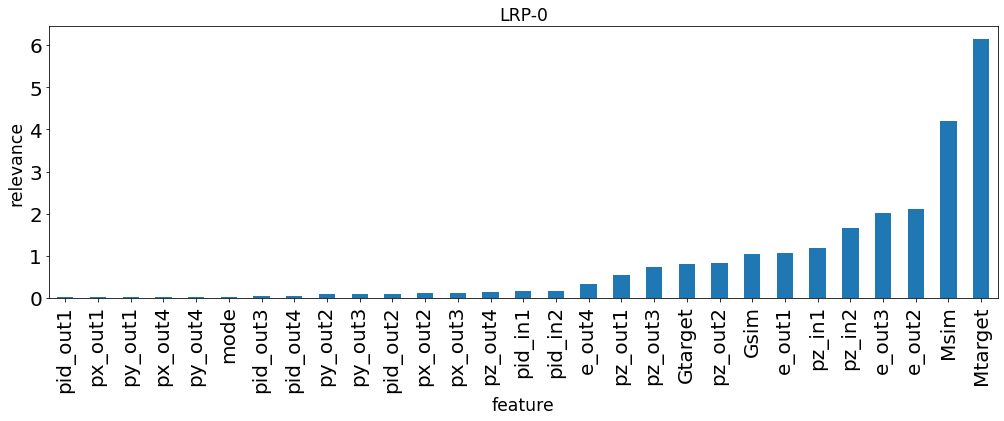

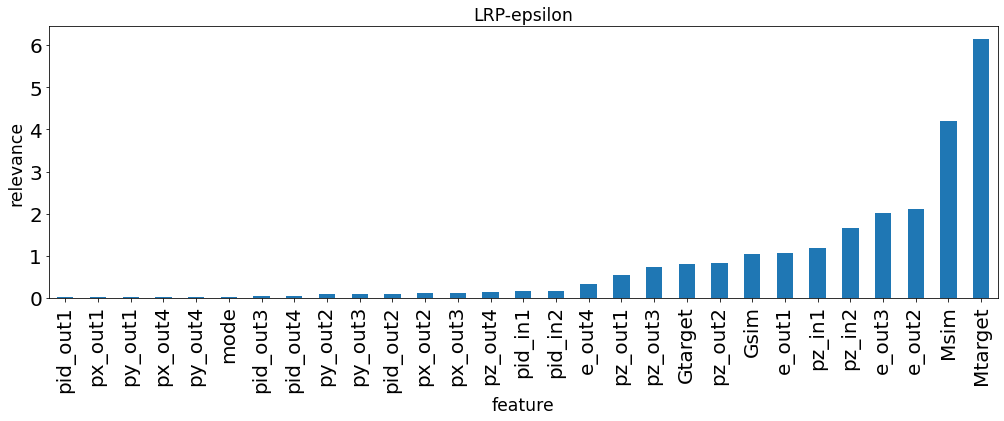

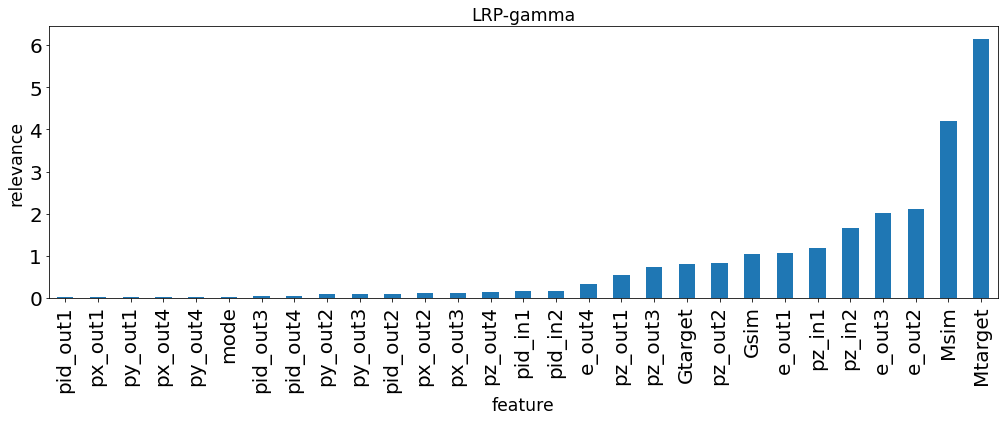

In [23]:
df = pd.DataFrame(np.array([features, rels_0]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='LRP-0', figsize=(17, 5))
del df

df = pd.DataFrame(np.array([features, rels_ep]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='LRP-epsilon', figsize=(17, 5))
del df

df = pd.DataFrame(np.array([features, rels_g]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='LRP-gamma', figsize=(17, 5))
del df

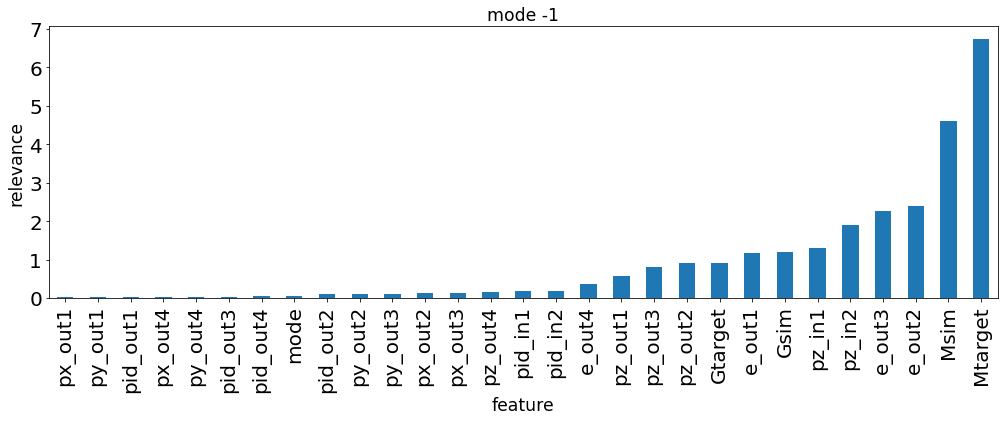

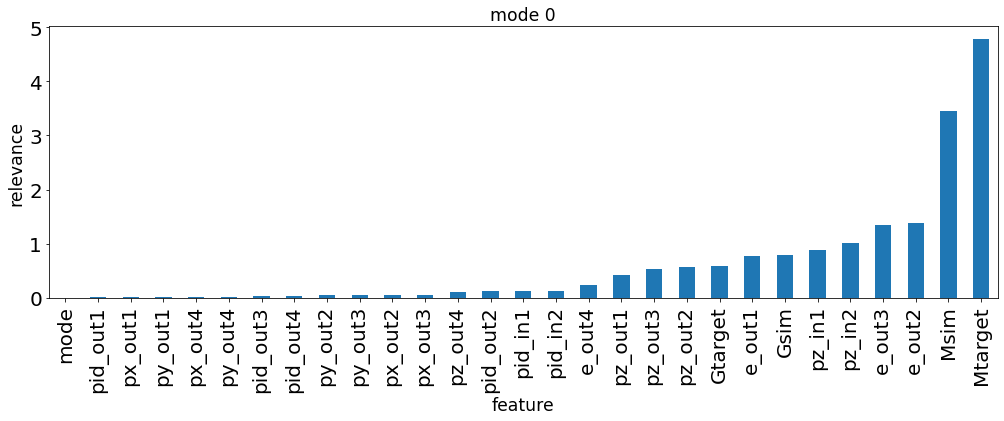

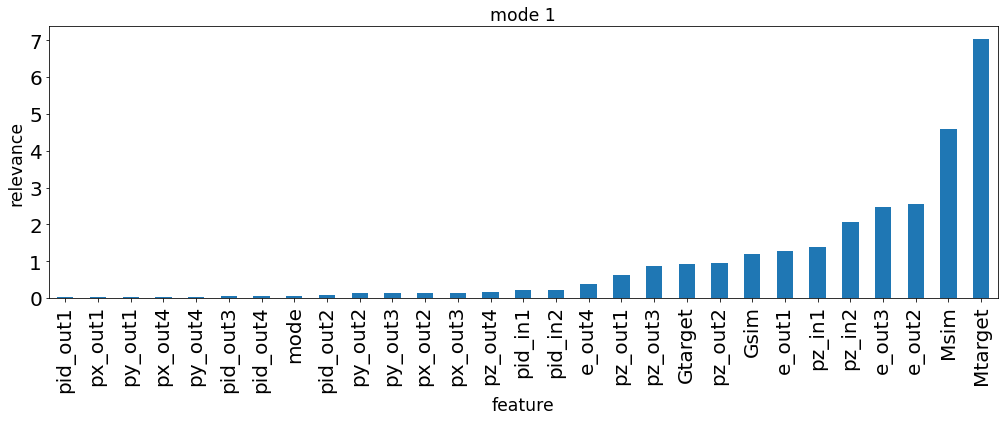

In [24]:
df_all = pd.DataFrame(X)
df_all.columns = features
rels = R_0[0]/Y[:, np.newaxis]
modes = [-1,0,1]
for b in modes:
    idx = df_all.index[df_all['mode']==b].tolist()
    rels_mode = np.abs([rels[idxi][:] for idxi in idx])
    ind = np.argpartition(rels_mode,int(0.95*len(rels_mode)), axis=0)
    ind = ind[:int(0.95*len(rels_mode)),:]
    rels_mode = rels_mode[ind[:,0]]
    rel_mode = pd.DataFrame(np.array([features, np.mean(rels_mode, axis=0)])).transpose()
    rel_mode.columns = ['feature', 'relevance']
    rel_mode.relevance = rel_mode.relevance.astype(float)
    rel_mode = rel_mode.sort_values(by=['relevance'])
    rel_mode.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='mode '+str(b), figsize=(17, 5))
    del rel_mode, rels_mode, ind, idx
del df_all, rels